# Image Inpainting with Autoencoder for Human Faces

## Introduction
This project focuses on image inpainting, a process of reconstructing missing or damaged parts of an image. The approach leverages autoencoder neural networks to learn and generate plausible completions for missing regions based on learned features.

## Dataset
This project uses a custom dataset of human face images stored in a directory structure. The dataset is loaded using a custom dataset class in PyTorch.

## Preprocessing
- Images are resized to 124×124 pixels.
- Data augmentation techniques such as random rotation, horizontal flip, affine transformations, and normalization to tensor format are applied.
- GPU acceleration is utilized for faster computation if available.

## Training
- The autoencoder is trained using the Adam optimizer and Mean Squared Error (MSE) loss.
- Training involves reconstructing images with randomly generated missing patches.

## Image Inpainting
- Missing patches are generated by setting random regions of the image to zero.
- The autoencoder learns to inpaint these missing regions based on the surrounding context.
- An autoencoder is employed, comprising an encoder and a decoder.
- The encoder compresses input images into a latent representation, while the decoder reconstructs the original images.
- The architecture consists of convolutional layers for both encoding and decoding.

## Visualization
- The final step involves visualizing different stages of the inpainting process:
 - Original images from the dataset.
 - Images with randomly generated missing patches.
 - Autoencoder inpainted images, demonstrating the network's ability to generate plausible completions.

In [1]:
#Importing necessary librarires
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm

from model1 import Autoencoder1
from model2 import Autoencoder2
from model3 import UNet
from dataset import CustomDataset

In [2]:
import warnings
# Suppress warnings
warnings.filterwarnings("ignore")

In [3]:
USE_GPU = True
num_class = 100
dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


### Dataset and Data Augmentation Summary:

- Image Size: All images are resized to 124x124 pixels.
- Number of Images: The dataset comprises 5000 images.
- Data Augmentation Techniques:
 - Resize: All images are resized to 124x124 pixels.
 - Random Rotation: Images are randomly rotated within a range of -20 to +20 degrees.
 - Random Horizontal Flip: Images are randomly flipped horizontally with a 50% probability.
 - Random Affine Transformations: Affine transformations are applied randomly with the following parameters:
   - Translation: Images are randomly translated by up to 10% of the width and height.
   - Shear: Images are randomly sheared by up to 20%.
   - Scale: Images are randomly scaled within the range of 80% to 120% of their original size.
 - To Tensor: Finally, the images are converted to PyTorch tensors.

In [4]:
image_size = (124, 124)
image_size2 = (120,120)
num_images = 5000


transform1 = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, translate=(0.1, 0.1), shear=0.2, scale=(0.8, 1.2)),
    transforms.ToTensor()
])

transform2 = transforms.Compose([
    transforms.Resize(image_size2),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, translate=(0.1, 0.1), shear=0.2, scale=(0.8, 1.2)),
    transforms.ToTensor()
])


In [5]:
dataset_path = 'Humans'
dataset1 = CustomDataset(dataset_path, transform=transform1, num_images=num_images)
dataloader1 = DataLoader(dataset1, batch_size=32, shuffle=True)

dataset2 = CustomDataset(dataset_path, transform=transform2, num_images=num_images)
dataloader2 = DataLoader(dataset2, batch_size=32, shuffle=True)

### Function: destroy_patches

#### Description:
This function destroys patches in input images by setting the pixel values in randomly selected regions to zero.

#### Parameters:
- `X`: Input tensor representing images with shape `(batch_size, channels, height, width)`.
- `patch_size`: Tuple specifying the size of the patch to destroy, `(patch_height, patch_width)`.

#### Returns:
- `X_destroyed`: Tensor representing images with randomly destroyed patches, with the same shape as the input `X`.

In [6]:
def destroy_patches(X, patch_size):
    X_destroyed = X.clone()
    for i in range(X.size(0)):
        x = np.random.randint(0, X.size(3) - patch_size[0])
        y = np.random.randint(0, X.size(2) - patch_size[1])
        X_destroyed[i, :, y:y+patch_size[1], x:x+patch_size[0]] = 0.0
    return X_destroyed

### Function: train_model

#### Description:
This function trains the autoencoder model on the given dataset. It runs for a specified number of epochs and updates the model parameters based on the loss between the original and reconstructed images.

#### Parameters:
- `model`: The autoencoder model to be trained.
- `dataloader`: The DataLoader containing the training data.


In [7]:
def train_model(model, dataloader):
    num_epochs = 30
    for epoch in range(num_epochs):
        with tqdm(total=len(dataloader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
            for data in dataloader:
                img = data.cuda()
                img_destroyed = destroy_patches(img, patch_size=(32, 32))
                output = model(img_destroyed)
                loss = criterion(output, img)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                pbar.set_postfix(loss=loss.item())
                pbar.update(1)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

### Function: test_model

#### Description:
This function tests the autoencoder model on the given dataset. It evaluates the model by reconstructing the images and returning the output along with the original and destroyed images.

#### Parameters:
- `model`: The autoencoder model to be trained.
- `dataloader`: The DataLoader containing the training data.

#### Returns:

- `output`: Reconstructed images by the autoencoder.
- `img_destroyed`: Images with randomly destroyed patches.
- `img`: Original images from the dataset.

In [8]:
def test_model(model, dataloader):
    # Testing the autoencoder
    model.eval()
    with torch.no_grad():
        for data in dataloader:
            img = data.cuda()
            img_destroyed = destroy_patches(img, patch_size=(32, 32))
            output = model(img_destroyed)
            break
    return output, img_destroyed, img

### Function: plot_reconstructed_images

#### Description:
This function visualizes the original images, images with missing patches, and the inpainted images produced by the autoencoder.

#### Parameters:
- `output`: Reconstructed images by the autoencoder.
- `img_destroyed`: Images with randomly destroyed patches.
- `img`: Original images from the dataset.

In [50]:
def plot_reconstructed_images(output, img_destroyed, img):
    # Convert to numpy for plotting
    n = 5
    img = img.cpu().numpy().transpose((0, 2, 3, 1))
    img_destroyed = img_destroyed.cpu().numpy().transpose((0, 2, 3, 1))
    output = output.cpu().numpy().transpose((0, 2, 3, 1))
    
    fig, axes = plt.subplots(3, n, figsize=(5, 4))

    # Randomly select n images from the dataset
    random_indices = random.sample(range(len(img)), n)

    axes[0, 2].set_title('The original images in the Dataset', fontweight='bold', loc='center')  
    axes[1, 2].set_title('Images with missing patch', fontweight='bold', loc='center')  
    axes[2, 2].set_title('Inpainted images', fontweight='bold', loc='center')  

    for i in range(n):
        # Original image
        axes[0, i].imshow(img[random_indices[i]])
        axes[0, i].axis('off')

        # Missing patch
        axes[1, i].imshow(img_destroyed[random_indices[i]])
        axes[1, i].axis('off')

        # Reconstructed image
        axes[2, i].imshow(output[random_indices[i]])
        axes[2, i].axis('off')

    plt.tight_layout()
    plt.show()

In [10]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model, path):
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model
    model_instance = model().cuda()
    model_instance.load_state_dict(torch.load(path))
    model_instance.eval()
    return model_instance

### Autoencoder1 Architecture

Here's the table representing the architecture of the `Autoencoder1` model:

| Layer (type)               | Input Size   | Output Size  | Param # |
|----------------------------|--------------|--------------|---------|
| Conv2d (3, 16, kernel_size=3, padding=1)    | 3x124x124    | 16x124x124   | 448     |
| ReLU                       | -            | -            | 0       |
| MaxPool2d (kernel_size=2, stride=2)         | -            | 16x62x62     | 0       |
| Conv2d (16, 8, kernel_size=3, padding=1)    | -            | 8x62x62      | 1160    |
| ReLU                       | -            | -            | 0       |
| MaxPool2d (kernel_size=2, stride=2)         | -            | 8x31x31      | 0       |
| Conv2d (8, 8, kernel_size=3, padding=1)     | -            | 8x31x31      | 584     |
| ReLU                       | -            | -            | 0       |
| MaxPool2d (kernel_size=2, stride=2)         | -            | 8x16x16      | 0       |
| Conv2d (8, 8, kernel_size=3, padding=1)     | -            | 8x16x16      | 584     |
| ReLU                       | -            | -            | 0       |
| Upsample (scale_factor=2, mode='nearest')   | -            | 8x32x32      | 0       |
| Conv2d (8, 8, kernel_size=3, padding=1)     | -            | 8x32x32      | 584     |
| ReLU                       | -            | -            | 0       |
| Upsample (scale_factor=2, mode='nearest')   | -            | 8x64x64      | 0       |
| Conv2d (8, 16, kernel_size=3, padding=1)    | -            | 16x64x64     | 1168    |
| ReLU                       | -            | -            | 0       |
| Upsample (scale_factor=2, mode='nearest')   | -            | 16x128x128   | 0       |
| Conv2d (16, 3, kernel_size=3, padding=1)    | -            | 3x128x128    | 435     |
| Sigmoid                    | -            | -            | 0       |
| Upsample (size=(124, 124), mode='bilinear', align_corners=False) | -  | 3x124x124    | 0       |


In [57]:
# model_path = 'autoencoder1.pth'
# # Check if model file exists
# if os.path.exists(model_path):
#     print("Loading model from file...")
#     autoencoder1 = load_model(Autoencoder1, model_path)
# else:
#     print("Model file not found. Training model...")
   
#     # Instantiate model, define loss and optimizer
#     autoencoder1 = Autoencoder1().cuda()
#     criterion = nn.MSELoss()
#     optimizer = optim.Adam(autoencoder1.parameters(), lr=0.001)
    
#     #Train the model
#     train_model(model=autoencoder1, dataloader=dataloader1)
    
#     # Save the model
#     save_model(autoencoder1, "autoencoder1.pth")
    
#     # Load the model
#     autoencoder1_loaded = Autoencoder1()
#     autoencoder1_loaded = load_model(autoencoder1_loaded, "autoencoder1.pth")

# Instantiate model, define loss and optimizer
autoencoder1 = Autoencoder1().cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder1.parameters(), lr=0.001)

#Train the model
train_model(model=autoencoder1, dataloader=dataloader1)

Epoch 1/30: 100%|██████████| 157/157 [02:11<00:00,  1.19batch/s, loss=0.0287]


Epoch [1/30], Loss: 0.0287


Epoch 2/30: 100%|██████████| 157/157 [02:07<00:00,  1.23batch/s, loss=0.026] 


Epoch [2/30], Loss: 0.0260


Epoch 3/30: 100%|██████████| 157/157 [02:08<00:00,  1.22batch/s, loss=0.0201]


Epoch [3/30], Loss: 0.0201


Epoch 4/30: 100%|██████████| 157/157 [02:08<00:00,  1.22batch/s, loss=0.0197]


Epoch [4/30], Loss: 0.0197


Epoch 5/30: 100%|██████████| 157/157 [02:12<00:00,  1.19batch/s, loss=0.0188]


Epoch [5/30], Loss: 0.0188


Epoch 6/30: 100%|██████████| 157/157 [02:17<00:00,  1.14batch/s, loss=0.0169]


Epoch [6/30], Loss: 0.0169


Epoch 7/30: 100%|██████████| 157/157 [02:08<00:00,  1.22batch/s, loss=0.013] 


Epoch [7/30], Loss: 0.0130


Epoch 8/30: 100%|██████████| 157/157 [02:10<00:00,  1.21batch/s, loss=0.012] 


Epoch [8/30], Loss: 0.0120


Epoch 9/30: 100%|██████████| 157/157 [02:10<00:00,  1.20batch/s, loss=0.0192]


Epoch [9/30], Loss: 0.0192


Epoch 10/30: 100%|██████████| 157/157 [02:10<00:00,  1.21batch/s, loss=0.0117]


Epoch [10/30], Loss: 0.0117


Epoch 11/30: 100%|██████████| 157/157 [02:09<00:00,  1.21batch/s, loss=0.0161]


Epoch [11/30], Loss: 0.0161


Epoch 12/30: 100%|██████████| 157/157 [02:11<00:00,  1.20batch/s, loss=0.0143]


Epoch [12/30], Loss: 0.0143


Epoch 13/30: 100%|██████████| 157/157 [02:09<00:00,  1.21batch/s, loss=0.0122]


Epoch [13/30], Loss: 0.0122


Epoch 14/30: 100%|██████████| 157/157 [02:10<00:00,  1.21batch/s, loss=0.0127]


Epoch [14/30], Loss: 0.0127


Epoch 15/30: 100%|██████████| 157/157 [02:10<00:00,  1.20batch/s, loss=0.0101]


Epoch [15/30], Loss: 0.0101


Epoch 16/30: 100%|██████████| 157/157 [02:10<00:00,  1.20batch/s, loss=0.0113]


Epoch [16/30], Loss: 0.0113


Epoch 17/30: 100%|██████████| 157/157 [02:10<00:00,  1.21batch/s, loss=0.00981]


Epoch [17/30], Loss: 0.0098


Epoch 18/30: 100%|██████████| 157/157 [02:10<00:00,  1.21batch/s, loss=0.0123]


Epoch [18/30], Loss: 0.0123


Epoch 19/30: 100%|██████████| 157/157 [02:11<00:00,  1.19batch/s, loss=0.00938]


Epoch [19/30], Loss: 0.0094


Epoch 20/30: 100%|██████████| 157/157 [02:08<00:00,  1.22batch/s, loss=0.0109] 


Epoch [20/30], Loss: 0.0109


Epoch 21/30: 100%|██████████| 157/157 [02:07<00:00,  1.23batch/s, loss=0.0113] 


Epoch [21/30], Loss: 0.0113


Epoch 22/30: 100%|██████████| 157/157 [02:03<00:00,  1.28batch/s, loss=0.00891]


Epoch [22/30], Loss: 0.0089


Epoch 23/30: 100%|██████████| 157/157 [02:05<00:00,  1.25batch/s, loss=0.0102] 


Epoch [23/30], Loss: 0.0102


Epoch 24/30: 100%|██████████| 157/157 [02:10<00:00,  1.20batch/s, loss=0.0115] 


Epoch [24/30], Loss: 0.0115


Epoch 25/30: 100%|██████████| 157/157 [02:09<00:00,  1.21batch/s, loss=0.00957]


Epoch [25/30], Loss: 0.0096


Epoch 26/30: 100%|██████████| 157/157 [02:09<00:00,  1.21batch/s, loss=0.0117] 


Epoch [26/30], Loss: 0.0117


Epoch 27/30: 100%|██████████| 157/157 [02:10<00:00,  1.21batch/s, loss=0.0134] 


Epoch [27/30], Loss: 0.0134


Epoch 28/30: 100%|██████████| 157/157 [02:09<00:00,  1.21batch/s, loss=0.0104] 


Epoch [28/30], Loss: 0.0104


Epoch 29/30: 100%|██████████| 157/157 [02:08<00:00,  1.22batch/s, loss=0.0109] 


Epoch [29/30], Loss: 0.0109


Epoch 30/30: 100%|██████████| 157/157 [02:10<00:00,  1.20batch/s, loss=0.012]  

Epoch [30/30], Loss: 0.0120


In [58]:
#Test model
output1, img_destroyed, img = test_model(model=autoencoder1, dataloader=dataloader1)

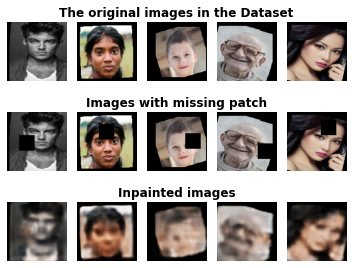

In [59]:
#Show reconstructed image
plot_reconstructed_images(output=output1, img_destroyed=img_destroyed, img=img)

### Autoencoder2 Architecture

Here's the table representing the architecture of the `Autoencoder2` model:

| Layer (type)                              | Input Size   | Output Size  | Param # |
|-------------------------------------------|--------------|--------------|---------|
| Conv2d (3, 64, kernel_size=3, padding=1)  | 3x124x124    | 64x124x124   | 1,792   |
| ReLU                                      | -            | -            | 0       |
| MaxPool2d (kernel_size=2, stride=2)       | -            | 64x62x62     | 0       |
| Conv2d (64, 128, kernel_size=3, padding=1)| -            | 128x62x62    | 73,856  |
| ReLU                                      | -            | -            | 0       |
| MaxPool2d (kernel_size=2, stride=2)       | -            | 128x31x31    | 0       |
| Conv2d (128, 256, kernel_size=3, padding=1)| -           | 256x31x31    | 295,168 |
| ReLU                                      | -            | -            | 0       |
| MaxPool2d (kernel_size=2, stride=2)       | -            | 256x15x15    | 0       |
| ConvTranspose2d (256, 128, kernel_size=2, stride=2) | - | 128x30x30 | 131,200 |
| ReLU                                      | -            | -            | 0       |
| ConvTranspose2d (128, 64, kernel_size=2, stride=2)  | - | 64x60x60  | 32,832  |
| ReLU                                      | -            | -            | 0       |
| ConvTranspose2d (64, 3, kernel_size=2, stride=2)    | - | 3x120x120 | 771     |
| Sigmoid                                   | -            | -            | 0       |


In [10]:
# model_path = 'autoencoder2.pth'
# # Check if model file exists
# if os.path.exists(model_path):
#     print("Loading model from file...")
#     autoencoder1 = load_model(Autoencoder2, model_path)
# else:
#     print("Model file not found. Training model...")
   
#     # Instantiate model, define loss and optimizer
#     autoencoder2 = Autoencoder2().cuda()
#     criterion = nn.MSELoss()
#     optimizer = optim.Adam(autoencoder2.parameters(), lr=0.001)

#     #Train the model
#     train_model(model=autoencoder2, dataloader=dataloader2)
    
#     # Save the model
#     save_model(autoencoder2, "autoencoder2.pth")
    
#     # Load the model
#     autoencoder2_loaded = Autoencoder2()
#     autoencoder2_loaded = load_model(autoencoder2_loaded, "autoencoder2.pth")

#Instantiate model, define loss and optimizer
autoencoder2 = Autoencoder2().cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder2.parameters(), lr=0.001)

#Train the model
train_model(model=autoencoder2, dataloader=dataloader2)

Epoch 1/30: 100%|██████████| 157/157 [02:16<00:00,  1.15batch/s, loss=0.0236]


Epoch [1/30], Loss: 0.0236


Epoch 2/30: 100%|██████████| 157/157 [02:06<00:00,  1.24batch/s, loss=0.0155]


Epoch [2/30], Loss: 0.0155


Epoch 3/30: 100%|██████████| 157/157 [02:05<00:00,  1.25batch/s, loss=0.0144] 


Epoch [3/30], Loss: 0.0144


Epoch 4/30: 100%|██████████| 157/157 [02:07<00:00,  1.23batch/s, loss=0.0103] 


Epoch [4/30], Loss: 0.0103


Epoch 5/30: 100%|██████████| 157/157 [02:05<00:00,  1.25batch/s, loss=0.0083] 


Epoch [5/30], Loss: 0.0083


Epoch 6/30: 100%|██████████| 157/157 [02:05<00:00,  1.25batch/s, loss=0.00524]


Epoch [6/30], Loss: 0.0052


Epoch 7/30: 100%|██████████| 157/157 [02:07<00:00,  1.23batch/s, loss=0.00735]


Epoch [7/30], Loss: 0.0073


Epoch 8/30: 100%|██████████| 157/157 [02:04<00:00,  1.26batch/s, loss=0.0077] 


Epoch [8/30], Loss: 0.0077


Epoch 9/30: 100%|██████████| 157/157 [02:06<00:00,  1.24batch/s, loss=0.0129] 


Epoch [9/30], Loss: 0.0129


Epoch 10/30: 100%|██████████| 157/157 [02:05<00:00,  1.25batch/s, loss=0.0119] 


Epoch [10/30], Loss: 0.0119


Epoch 11/30: 100%|██████████| 157/157 [02:05<00:00,  1.25batch/s, loss=0.00556]


Epoch [11/30], Loss: 0.0056


Epoch 12/30: 100%|██████████| 157/157 [02:08<00:00,  1.22batch/s, loss=0.0103] 


Epoch [12/30], Loss: 0.0103


Epoch 13/30: 100%|██████████| 157/157 [02:05<00:00,  1.25batch/s, loss=0.00951]


Epoch [13/30], Loss: 0.0095


Epoch 14/30: 100%|██████████| 157/157 [02:08<00:00,  1.23batch/s, loss=0.00925]


Epoch [14/30], Loss: 0.0092


Epoch 15/30: 100%|██████████| 157/157 [02:07<00:00,  1.23batch/s, loss=0.00619]


Epoch [15/30], Loss: 0.0062


Epoch 16/30: 100%|██████████| 157/157 [02:12<00:00,  1.19batch/s, loss=0.00932]


Epoch [16/30], Loss: 0.0093


Epoch 17/30: 100%|██████████| 157/157 [02:14<00:00,  1.17batch/s, loss=0.00687]


Epoch [17/30], Loss: 0.0069


Epoch 18/30: 100%|██████████| 157/157 [02:15<00:00,  1.16batch/s, loss=0.00998]


Epoch [18/30], Loss: 0.0100


Epoch 19/30: 100%|██████████| 157/157 [02:16<00:00,  1.15batch/s, loss=0.00593]


Epoch [19/30], Loss: 0.0059


Epoch 20/30: 100%|██████████| 157/157 [02:14<00:00,  1.17batch/s, loss=0.00916]


Epoch [20/30], Loss: 0.0092


Epoch 21/30: 100%|██████████| 157/157 [02:14<00:00,  1.17batch/s, loss=0.00646]


Epoch [21/30], Loss: 0.0065


Epoch 22/30: 100%|██████████| 157/157 [02:14<00:00,  1.17batch/s, loss=0.00876]


Epoch [22/30], Loss: 0.0088


Epoch 23/30: 100%|██████████| 157/157 [02:16<00:00,  1.15batch/s, loss=0.011]  


Epoch [23/30], Loss: 0.0110


Epoch 24/30: 100%|██████████| 157/157 [02:18<00:00,  1.13batch/s, loss=0.00824]


Epoch [24/30], Loss: 0.0082


Epoch 25/30: 100%|██████████| 157/157 [02:19<00:00,  1.13batch/s, loss=0.00626]


Epoch [25/30], Loss: 0.0063


Epoch 26/30: 100%|██████████| 157/157 [02:17<00:00,  1.14batch/s, loss=0.00722]


Epoch [26/30], Loss: 0.0072


Epoch 27/30: 100%|██████████| 157/157 [02:18<00:00,  1.14batch/s, loss=0.00661]


Epoch [27/30], Loss: 0.0066


Epoch 28/30: 100%|██████████| 157/157 [02:17<00:00,  1.14batch/s, loss=0.0077] 


Epoch [28/30], Loss: 0.0077


Epoch 29/30: 100%|██████████| 157/157 [02:16<00:00,  1.15batch/s, loss=0.00735]


Epoch [29/30], Loss: 0.0074


Epoch 30/30: 100%|██████████| 157/157 [02:18<00:00,  1.13batch/s, loss=0.00624]

Epoch [30/30], Loss: 0.0062


In [27]:
#Test model
output2, img_destroyed, img = test_model(model=autoencoder2, dataloader=dataloader2)

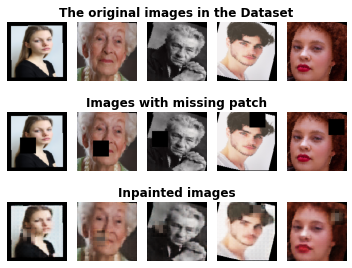

In [31]:
#Show reconstructed image
plot_reconstructed_images(output=output2, img_destroyed=img_destroyed, img=img)

### U-Net Architecture

| Layer            | Operation                                        | Input Size   | Output Size  |
|------------------|--------------------------------------------------|--------------|--------------|
| Input            | -                                                | (batch_size, 3, 256, 256) | (batch_size, 3, 256, 256) |
| Encoder1         | Conv2d, ReLU, Conv2d, ReLU                       | (batch_size, 3, 256, 256) | (batch_size, 64, 256, 256) |
| Max Pooling      | MaxPool2d                                        | (batch_size, 64, 256, 256) | (batch_size, 64, 128, 128) |
| Encoder2         | Conv2d, ReLU, Conv2d, ReLU                       | (batch_size, 64, 128, 128) | (batch_size, 128, 128, 128) |
| Max Pooling      | MaxPool2d                                        | (batch_size, 128, 128, 128) | (batch_size, 128, 64, 64) |
| Encoder3         | Conv2d, ReLU, Conv2d, ReLU                       | (batch_size, 128, 64, 64) | (batch_size, 256, 64, 64) |
| Max Pooling      | MaxPool2d                                        | (batch_size, 256, 64, 64) | (batch_size, 256, 32, 32) |
| Encoder4         | Conv2d, ReLU, Conv2d, ReLU                       | (batch_size, 256, 32, 32) | (batch_size, 512, 32, 32) |
| Max Pooling      | MaxPool2d                                        | (batch_size, 512, 32, 32) | (batch_size, 512, 16, 16) |
| Bottleneck       | Conv2d, ReLU, Conv2d, ReLU                       | (batch_size, 512, 16, 16) | (batch_size, 1024, 16, 16) |
| Upconvolution4   | ConvTranspose2d                                  | (batch_size, 1024, 16, 16) | (batch_size, 512, 32, 32) |
| Decoder4         | Concatenation, Conv2d, ReLU, Conv2d, ReLU        | (batch_size, 512, 32, 32) | (batch_size, 512, 32, 32) |
| Upconvolution3   | ConvTranspose2d                                  | (batch_size, 512, 32, 32) | (batch_size, 256, 64, 64) |
| Decoder3         | Concatenation, Conv2d, ReLU, Conv2d, ReLU        | (batch_size, 256, 64, 64) | (batch_size, 256, 64, 64) |
| Upconvolution2   | ConvTranspose2d                                  | (batch_size, 256, 64, 64) | (batch_size, 128, 128, 128) |
| Decoder2         | Concatenation, Conv2d, ReLU, Conv2d, ReLU        | (batch_size, 128, 128, 128) | (batch_size, 128, 128, 128) |
| Upconvolution1   | ConvTranspose2d                                  | (batch_size, 128, 128, 128) | (batch_size, 64, 256, 256) |
| Decoder1         | Concatenation, Conv2d, ReLU, Conv2d, ReLU        | (batch_size, 64, 256, 256) | (batch_size, 64, 256, 256) |
| Convolution Last | Conv2d, Sigmoid                                  | (batch_size, 64, 256, 256) | (batch_size, 3, 256, 256) |


In [13]:
# model_path = 'unet.pth'
# # Check if model file exists
# if os.path.exists(model_path):
#     print("Loading model from file...")
#     unet = load_model(Unet, model_path)
# else:
#     print("Model file not found. Training model...")
    
#     # Instantiate model, define loss and optimizer
#     unet = UNet().cuda()
#     criterion = nn.MSELoss()
#     optimizer = optim.Adam(unet.parameters(), lr=0.001)

#     #Train the model
#     train_model(model=unet, dataloader=dataloader1)

#     # Save the model
#     save_model(unet, "unet.pth")
    
#     # Load the model
#     unet_loaded = UNet()
#     unet_loaded = load_model(unet_loaded, "unet.pth")

# Instantiate model, define loss and optimizer
unet = UNet().cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(unet.parameters(), lr=0.001)

#Train the model
train_model(model=unet, dataloader=dataloader1)

Epoch 1/30: 100%|██████████| 157/157 [02:40<00:00,  1.02s/batch, loss=0.0115] 


Epoch [1/30], Loss: 0.0115


Epoch 2/30: 100%|██████████| 157/157 [02:45<00:00,  1.06s/batch, loss=0.00349]


Epoch [2/30], Loss: 0.0035


Epoch 3/30: 100%|██████████| 157/157 [02:42<00:00,  1.04s/batch, loss=0.00508]


Epoch [3/30], Loss: 0.0051


Epoch 4/30: 100%|██████████| 157/157 [02:42<00:00,  1.03s/batch, loss=0.00222]


Epoch [4/30], Loss: 0.0022


Epoch 5/30: 100%|██████████| 157/157 [02:42<00:00,  1.03s/batch, loss=0.00186]


Epoch [5/30], Loss: 0.0019


Epoch 6/30: 100%|██████████| 157/157 [02:40<00:00,  1.02s/batch, loss=0.00225]


Epoch [6/30], Loss: 0.0023


Epoch 7/30: 100%|██████████| 157/157 [02:40<00:00,  1.02s/batch, loss=0.00161]


Epoch [7/30], Loss: 0.0016


Epoch 8/30: 100%|██████████| 157/157 [02:40<00:00,  1.02s/batch, loss=0.00197]


Epoch [8/30], Loss: 0.0020


Epoch 9/30: 100%|██████████| 157/157 [02:42<00:00,  1.03s/batch, loss=0.00203]


Epoch [9/30], Loss: 0.0020


Epoch 10/30: 100%|██████████| 157/157 [02:40<00:00,  1.03s/batch, loss=0.00156]


Epoch [10/30], Loss: 0.0016


Epoch 11/30: 100%|██████████| 157/157 [02:41<00:00,  1.03s/batch, loss=0.00118]


Epoch [11/30], Loss: 0.0012


Epoch 12/30: 100%|██████████| 157/157 [02:39<00:00,  1.02s/batch, loss=0.00121]


Epoch [12/30], Loss: 0.0012


Epoch 13/30: 100%|██████████| 157/157 [02:37<00:00,  1.01s/batch, loss=0.00197]


Epoch [13/30], Loss: 0.0020


Epoch 14/30: 100%|██████████| 157/157 [02:39<00:00,  1.02s/batch, loss=0.00137]


Epoch [14/30], Loss: 0.0014


Epoch 15/30: 100%|██████████| 157/157 [02:40<00:00,  1.02s/batch, loss=0.00164]


Epoch [15/30], Loss: 0.0016


Epoch 16/30: 100%|██████████| 157/157 [02:39<00:00,  1.02s/batch, loss=0.00225]


Epoch [16/30], Loss: 0.0022


Epoch 17/30: 100%|██████████| 157/157 [02:38<00:00,  1.01s/batch, loss=0.00117]


Epoch [17/30], Loss: 0.0012


Epoch 18/30: 100%|██████████| 157/157 [02:40<00:00,  1.02s/batch, loss=0.00109]


Epoch [18/30], Loss: 0.0011


Epoch 19/30: 100%|██████████| 157/157 [02:40<00:00,  1.02s/batch, loss=0.00197]


Epoch [19/30], Loss: 0.0020


Epoch 20/30: 100%|██████████| 157/157 [02:38<00:00,  1.01s/batch, loss=0.00165]


Epoch [20/30], Loss: 0.0017


Epoch 21/30: 100%|██████████| 157/157 [02:37<00:00,  1.01s/batch, loss=0.00112]


Epoch [21/30], Loss: 0.0011


Epoch 22/30: 100%|██████████| 157/157 [02:37<00:00,  1.00s/batch, loss=0.000605]


Epoch [22/30], Loss: 0.0006


Epoch 23/30: 100%|██████████| 157/157 [02:38<00:00,  1.01s/batch, loss=0.00111]


Epoch [23/30], Loss: 0.0011


Epoch 24/30: 100%|██████████| 157/157 [02:37<00:00,  1.00s/batch, loss=0.00134] 


Epoch [24/30], Loss: 0.0013


Epoch 25/30: 100%|██████████| 157/157 [02:35<00:00,  1.01batch/s, loss=0.00103]


Epoch [25/30], Loss: 0.0010


Epoch 26/30: 100%|██████████| 157/157 [02:33<00:00,  1.02batch/s, loss=0.00168] 


Epoch [26/30], Loss: 0.0017


Epoch 27/30: 100%|██████████| 157/157 [02:36<00:00,  1.01batch/s, loss=0.00161]


Epoch [27/30], Loss: 0.0016


Epoch 28/30: 100%|██████████| 157/157 [02:36<00:00,  1.01batch/s, loss=0.00148] 


Epoch [28/30], Loss: 0.0015


Epoch 29/30: 100%|██████████| 157/157 [02:36<00:00,  1.00batch/s, loss=0.00159]


Epoch [29/30], Loss: 0.0016


Epoch 30/30: 100%|██████████| 157/157 [02:35<00:00,  1.01batch/s, loss=0.00136] 

Epoch [30/30], Loss: 0.0014


In [32]:
#Test model
output3, img_destroyed, img = test_model(model=unet, dataloader=dataloader1)

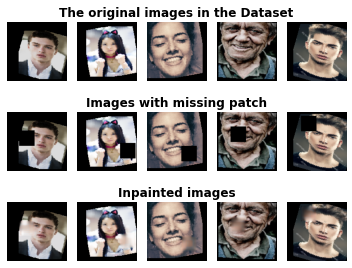

In [55]:
#Show reconstructed image
plot_reconstructed_images(output=output3, img_destroyed=img_destroyed, img=img)